In [2]:
from input.heart_import import get_heart_data
from sklearn.linear_model import LogisticRegression

In [3]:
df = get_heart_data()

heart data import succesful


In [4]:
import numpy as np

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:
# TODO: make 

## Standard Logistic Regression

In [6]:
# 5-fold CV:

accuracies = []
for i in range(5):
    test = df.sample(frac=0.2, random_state=i)
    train = df.drop(test.index)
    
    X_train = train.drop(train.columns[0], axis=1)
    y_train = train.iloc[:, 0]
    
    X_test = test.drop(test.columns[0], axis=1)
    y_test = test.iloc[:, 0]   
    
    scaler = StandardScaler()
    pca = PCA(n_components=1)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    pca.fit(X_train)
    #print(pca.explained_variance_ratio_)
    
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    
    

    lr = LogisticRegression(solver='liblinear', max_iter=1000)
    lr.fit(X_train, y_train)
    
    
    print([lr.coef_, lr.intercept_])
    accuracy = sum(lr.predict(X_test) == y_test) / len(y_test)
    
    accuracies.append(accuracy)
    
print('Mean accuracy: ' + str(round(np.mean(accuracies), 3)))

[array([[-0.96317234]]), array([0.24227354])]
[array([[-1.0274986]]), array([0.33807534])]
[array([[0.93274834]]), array([0.38138323])]
[array([[1.06018426]]), array([0.09013158])]
[array([[-0.96748667]]), array([0.17986192])]
Mean accuracy: 0.856


In [7]:
lr.intercept_
lr.coef_

array([[-0.96748667]])

## Bayesian Logistic Regression

In [16]:
from scipy import stats

def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [8]:
N_COMPONENTS = 2

i = 0
test = df.sample(frac=0.2, random_state=i)
train = df.drop(test.index)

X_train = train.drop(train.columns[0], axis=1)
y_train = train.iloc[:, 0]

X_test = test.drop(test.columns[0], axis=1)
y_test = test.iloc[:, 0]   

scaler = StandardScaler()
pca = PCA(n_components=N_COMPONENTS)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca.fit(X_train)
print(sum(pca.explained_variance_ratio_))

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

0.31444484381501425


In [9]:
X_train @ [[1], [2]]

array([[ 3.2171285 ],
       [-2.01147633],
       [-3.6181394 ],
       [-4.61051353],
       [ 0.05465944],
       [ 2.91862645],
       [-2.07264919],
       [-2.2126594 ],
       [-0.32133204],
       [ 2.11254942],
       [ 2.40935968],
       [ 0.08679882],
       [ 4.5753559 ],
       [-3.15519884],
       [ 2.36886612],
       [-0.73567652],
       [-3.98217498],
       [ 4.21941188],
       [-6.02809553],
       [ 1.580558  ],
       [-2.82741147],
       [ 4.93361272],
       [ 0.84243892],
       [-5.103074  ],
       [-3.80472406],
       [-5.79437828],
       [ 0.57324049],
       [ 0.69494179],
       [ 0.9087736 ],
       [-2.61339917],
       [ 2.16514543],
       [ 3.74564181],
       [ 1.88008627],
       [-1.63803605],
       [-0.02659504],
       [ 3.16883584],
       [-2.91373767],
       [-3.27300889],
       [-2.09508206],
       [-0.0803047 ],
       [-0.68422841],
       [ 0.11716167],
       [ 2.70501044],
       [-0.65567005],
       [ 0.64685602],
       [-4

In [10]:
import matplotlib.pyplot as plt

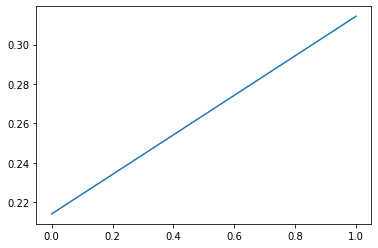

In [11]:

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [12]:
import pymc3 as pm

In [31]:
trace['beta'].std(0)

array([0.12003033, 0.12558566])

In [ ]:
for i in range(1,10):

    model = pm.Model()

    current_toefl = parts[i]['TOEFL Score']
    current_gre = parts[i]['GRE Score']

    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'])
        beta = from_posterior('beta', trace['beta'])

        # Expected value of outcome
        mu = alpha + beta * current_toefl

        # Likelihood (sampling distribution) of observations
        gre_obs = pm.Normal('gre_obs', mu=mu, sigma = 100, observed = current_gre)

        # draw 1000 posterior samples
        trace = pm.sample(1000, tune=5000)
        traces.append(trace)

In [ ]:
def fit_new_prior(param, trace):
    mus = trace[param].mean(0)
    stds = trace[param].std(0)
    return mus, stds

In [ ]:
# WITH NEW PRIORS EACH TIME
for i in range(1,10):

    model = pm.Model()

    current_toefl = parts[i]['TOEFL Score']
    current_gre = parts[i]['GRE Score']

    with model:
        # Priors are posteriors from previous iteration
        mus, stds = fit_new_prior('beta', trace)
        beta = pm.StudentT('beta', mu = mus, sd=stds)
        

        # Expected value of outcome
        mu = alpha + beta * current_toefl

        # Likelihood (sampling distribution) of observations
        gre_obs = pm.Normal('gre_obs', mu=mu, sigma = 100, observed = current_gre)

        # draw 1000 posterior samples
        trace = pm.sample(1000, tune=5000)
        traces.append(trace)

In [59]:
np.cov(trace['betas'].T)

array([[ 0.0141758 , -0.00272633, -0.00156967],
       [-0.00272633,  0.01558529,  0.00045762],
       [-0.00156967,  0.00045762,  0.03277217]])

In [65]:
trace['betas'].mean(0) # 0 to get average per column

array([-1.00446184,  0.36138033,  0.24289263])

In [ ]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])

# Calculate covariance matrix 
cov_mat(X.T) # (or with np.cov(X.T))

In [57]:
trace[betas]

array([[-0.96946396,  0.32615568,  0.17405372],
       [-0.96946396,  0.32615568,  0.17405372],
       [-1.00509231,  0.23809229,  0.34210688],
       ...,
       [-1.09197248,  0.29486768, -0.12930216],
       [-1.04469627,  0.21689676,  0.65401778],
       [-0.98819844,  0.34594699, -0.15527596]])

In [50]:
intercept = [[1]] * len(X_train)
X_train_with_intercept = np.append(X_train, intercept, axis = 1)

In [52]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [51]:
X_train_with_intercept

array([[ 1.52678487e+00,  8.45171812e-01,  1.00000000e+00],
       [-1.34835166e+00, -3.31562337e-01,  1.00000000e+00],
       [-2.75101976e+00, -4.33559821e-01,  1.00000000e+00],
       [-2.52844036e+00, -1.04103658e+00,  1.00000000e+00],
       [-1.39417922e+00,  7.24419328e-01,  1.00000000e+00],
       [-5.81104389e-01,  1.74986542e+00,  1.00000000e+00],
       [-1.92826114e+00, -7.21940240e-02,  1.00000000e+00],
       [-1.54576322e+00, -3.33448092e-01,  1.00000000e+00],
       [-2.35289868e+00,  1.01578332e+00,  1.00000000e+00],
       [ 1.06562703e+00,  5.23461195e-01,  1.00000000e+00],
       [-1.37890388e+00,  1.89413178e+00,  1.00000000e+00],
       [-2.66466365e+00,  1.37573123e+00,  1.00000000e+00],
       [ 3.43016415e-01,  2.11616974e+00,  1.00000000e+00],
       [-1.78891978e+00, -6.83139533e-01,  1.00000000e+00],
       [-7.46977561e-01,  1.55792184e+00,  1.00000000e+00],
       [ 1.15051020e+00, -9.43093363e-01,  1.00000000e+00],
       [-2.08621031e+00, -9.47982334e-01

In [33]:
# WORKS:

with pm.Model() as model: 
    
    # Define priors
    #intercept = pm.Normal('Intercept', 0, sd=20)
    beta = pm.Normal('beta', mu = [0], sd=10, shape = N_COMPONENTS)
    alpha = pm.Normal('alpha', 0, sd=10, shape = 1)
    #price_coef = pm.Normal('price', 0, sd=20)
    
    
    #p = pm.math.sigmoid(X_train @ beta + )
    p = pm.math.invlogit(X_train @ beta + alpha)
    
    
    # Define likelihood
    y = pm.Bernoulli('y', p, observed=y_train)
    #WTP=pm.Deterministic('WTP',-x_coeff/price_coef)

    # Inference!
    trace = pm.sample(2000)
    
pm.traceplot(trace)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'float'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1547.21draws/s]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136f796a0>,
      dtype=object)

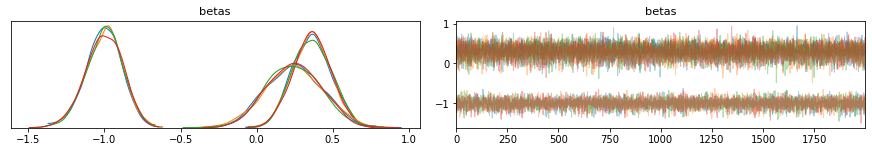

In [55]:
traces = []

with pm.Model() as model: 
    
    # Define priors
    #intercept = pm.Normal('Intercept', 0, sd=20)
    #beta = pm.Normal('beta', mu = [0], sd=10, shape = N_COMPONENTS)
    #alpha = pm.Normal('alpha', 0, sd=10, shape = 1)
    #price_coef = pm.Normal('price', 0, sd=20)
    
    mu = np.zeros(3)
    cov = np.identity(3) # gives 3x3 identity matrix
    betas = pm.MvNormal('betas', mu = mu, cov = cov, shape = 3)
    
    
    
    #p = pm.math.sigmoid(X_train @ beta + )
    p = pm.math.invlogit(X_train_with_intercept @ betas)
    
    
    # Define likelihood
    y = pm.Bernoulli('y', p, observed=y_train)
    #WTP=pm.Deterministic('WTP',-x_coeff/price_coef)

    # Inference!
    trace = pm.sample(2000)
    
pm.traceplot(trace)

In [34]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [27]:
import pandas as pd
pd.DataFrame(trace['beta']).mean(axis=0)

0   -1.019562
1    0.367327
dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c219340>,
      dtype=object)

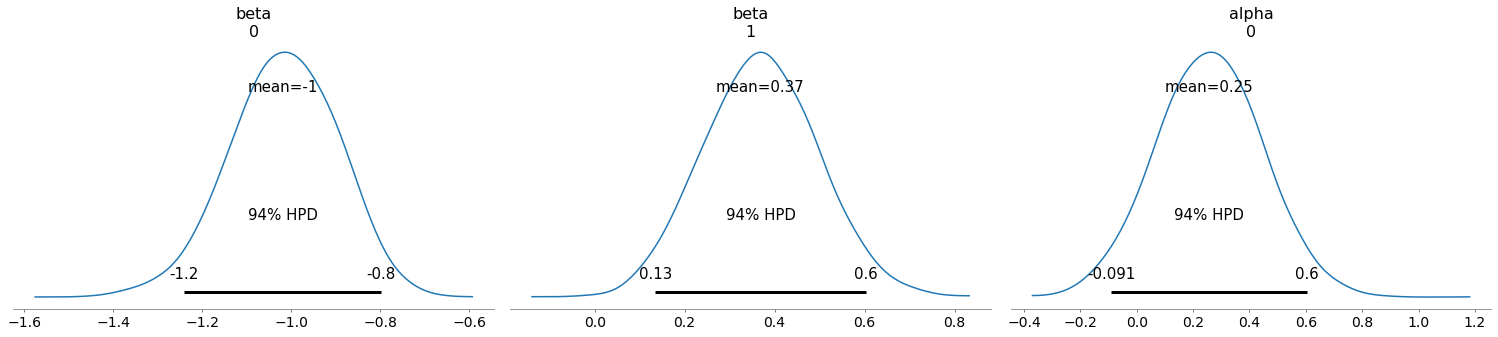

In [14]:
pm.plot_posterior(trace)

In [15]:
lr = LogisticRegression(solver='liblinear', max_iter=1000)
lr.fit(X_train, y_train)


print([lr.coef_, lr.intercept_])
accuracy = sum(lr.predict(X_test) == y_test) / len(y_test)
print(accuracy)


[array([[-0.98447627,  0.35392307]]), array([0.24018707])]
0.8524590163934426


In [44]:
lr = LogisticRegression()
bayes_lr.coef = 2
bayes_lr.intercept = 1

NameError: name 'x_train' is not defined

array([-1.01956158,  0.36732687])

In [52]:
import math

def sigmoid(x):
  return(1 / (1 + math.exp(-x)))

In [53]:
sigmoid(2e-05 * X_train + 0.17)

TypeError: only size-1 arrays can be converted to Python scalars

In [62]:
def predict(X, betas):
    Xb = np.array(X) * betas[1] + betas[0]
    return 1. / (1 + np.exp(-Xb))

In [63]:
predict(X_train, [0.17, 2e-05])

array([[0.54240552],
       [0.54239125],
       [0.54238428],
       [0.54238539],
       [0.54239102],
       [0.54239506],
       [0.54238837],
       [0.54239027],
       [0.54238626],
       [0.54240323],
       [0.5423911 ],
       [0.54238471],
       [0.54239964],
       [0.54238906],
       [0.54239423],
       [0.54240365],
       [0.54238758],
       [0.54240203],
       [0.54239778],
       [0.54238986],
       [0.54238857],
       [0.54239107],
       [0.54239351],
       [0.54238221],
       [0.54239773],
       [0.54238306],
       [0.54239294],
       [0.54239354],
       [0.54238564],
       [0.54239638],
       [0.54238918],
       [0.54239007],
       [0.54239019],
       [0.54239162],
       [0.54240199],
       [0.5423963 ],
       [0.54238447],
       [0.54238479],
       [0.54238684],
       [0.54239215],
       [0.54238753],
       [0.54238676],
       [0.54239843],
       [0.54238966],
       [0.54238594],
       [0.54238596],
       [0.54238563],
       [0.542